# Classification
Classification models in machine learning are tasked with predicting discrete, or qualitative, labels rather than continuous, or quantitative, ones. Many algorithms are capable of being trained for either type of problem (e.g. decision trees) while some are very specific to one type or the other (e.g. linear regression and logistic regression).

## MNIST
The **MNIST** data set is one of the most widely used data sets for classification model benchmarking. The set contains 70,000 small grayscale images of handwritten digits 0-9 with each digit having an assigned label indicating what number it represents. Nearly every practitioner in ML has either used or heard of the MNIST data set. Luckily, it is built in and available through the **Scikit-Learn** Python package.

In [1]:
# Download and check properties of MNIST
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

X, y = mnist['data'], mnist['target']
print('Image set size:', X.shape, 'Image labels:', y.shape)

Image set size: (70000, 784) Image labels: (70000,)


Using the `.shape` method, the MNIST data set shows 70,000 rows and 784 columns in the data set. The 784 columns represent each pixel's intensity on a 0-255 scale with '0' being all white and '255' all black with shades of gray in between. Each image is 28x28 pixes which is where '784' comes from (i.e. 28 x 28 = 784). The first digit/label (which happens to be a '5') is shown below.

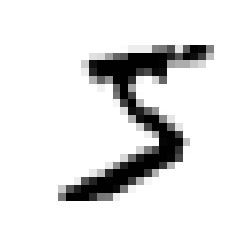

Label for first digit: 5


In [2]:
# Display first digit in data set
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis('off')

plt.show()

print('Label for first digit:', y[0])

The code below displays the first 100 digits of the MNIST data set. Notice that `.astype()` is used to convert the labels from strings to integers. This helps later on when building the classification model since strings are not the expected data type when training most ML models.

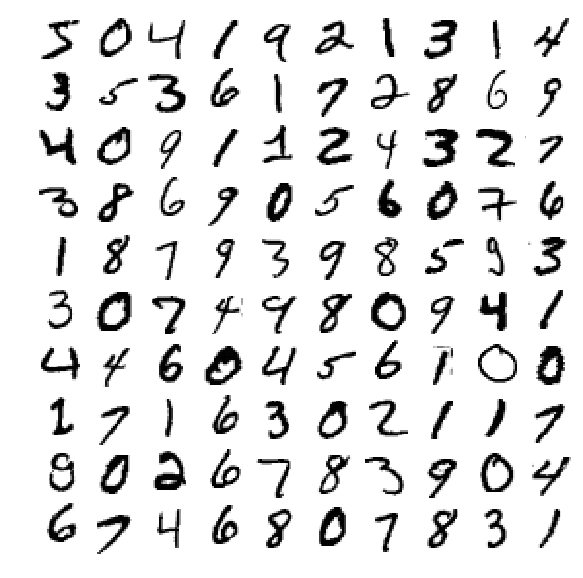

In [3]:
# Display first 100 images on MNIST
import numpy as np
y = y.astype(np.uint8)

# Function to display 100 images in 10x10 grid
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis('off')

plt.figure(figsize=(15, 10))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)

plt.show()

Before doing anything further, best practice dictates creating training and testing data sets. MNIST comes pre-split and shuffled with comparible representation of each digit so there shouldn't be any digits missing from either set.

In [0]:
# Create training and testing data sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary classifiers
Binary classifiers in ML, as the name suggests, work on problems where there are two possible classes each observation label can take. For example, below is code for creating a '5 classifier' for determining whether or not a digit is a 5 or not. The algorithm used, `SGDClassifier` stands for **Stochastic Gradient Descent** which itself is *not* a classification algorithm, but rather an *optimization* algorithm that 'sits on top' of a linear classifier (in the function's default, a **Support Vector Machine**, or **SVM**) and helps find its optimal parameters.

In [5]:
# Import SGD Classifier
from sklearn.linear_model import SGDClassifier

# Create training and testing data sets
y_train_5 = (y_train == 5) # Creates a vector of booleans: 5=True, Not 5=False
y_test_5 = (y_test == 5)

# Fit model to training data
sgd_clf = SGDClassifier(max_iter=1000, 
                        tol=1e-3, 
                        random_state=734)

sgd_clf.fit(X_train, y_train_5)

# Predict label of first digit in data set ('5')
sgd_clf.predict([some_digit])

array([False])

The returned value 'True' or 'False' indicates what the classifier predicted -- 5 or not-5. Now the model should be evaluated as a whole when making predictions across the entire training data set. As before, cross-validation allows a ML model to be trained and evaluated multiple times prior to using the testing data set for a final evaluation.

In [6]:
# Cross-validate SGD model using 3 folds and accuracy as the performance metric
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, 
                X_train, 
                y_train_5, 
                cv=3, 
                scoring='accuracy')

array([0.9639, 0.9578, 0.9572])

Each tested fold in the data set returns an **Accuracy** of ~95% or greater which is very good, however, keep in mind that only about 10% of the data set is the number '5' so always guessing a digit is a *not* a '5' means ~90% Accuracy most of the time. This is a prime example of why Accuracy is not a good performance measure when dealing with unbalanced data sets -- data sets when some labels appear far greater than others.

## Confusion Matrix
The **Confusion Matrix** can provide a much better illustration for how well a classifier performs. Using the `cross_val_predict` function with the SGD classifier returns the predicted classes for each observation based on the **decision threshold**, 0.5 (this is the default in Scikit-Learn). Then, the actual labels can be compared to the predicted labels using the `confusion_matrix` function.

In [7]:
# Import cross-validation and confusion matrix packages
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import pandas as pd

# Predict classes using cross_val_predict with SGD classifier
y_train_pred = cross_val_predict(sgd_clf, 
                                 X_train, 
                                 y_train_5, 
                                 cv=3)

# Compared predictions to actual labels
# confusion_matrix(y_train_5, y_train_pred)

print(pd.DataFrame(confusion_matrix(y_train_5,
                                    y_train_pred,
                                    labels=[0,1]), 
                                    index=['actual:non-5', 'actual:5'], 
                                    columns=['predicted:non-5', 'predicted:5'])
)

              predicted:non-5  predicted:5
actual:non-5            53588          991
actual:5                 1431         3990


The confusion matrix is a 2x2 matrix. The Scikit-Learn function returns rows representing the *actual* class and columns representing the *predicted* class. In the confusion matrix above, the first row considers *non-5* predictions (i.e. the 'negative' class or label) while the second row considers *5* predictions. The diagonals indicate **True Negatives** and **True Positives** while **False Negatives** and **False Positives** fall along the off-diagonals. A perfect classifer would only have values in the diagonals and zeros in the off-diagonals.

However, remember that other metrics exist that can aid in binary classifier evaluation like **Precision**, **Recall**, and their combined metric, **F1 Score**. Precision is, intuitively, the ability of the classifier not to label as positive (i.e. a '5') a sample that is negative whereas, Recall is, intuitively, the ability of the classifier to find *all* the positive samples. F1 Score combines Precision and Recall using their [*harmonic mean*](https://en.wikipedia.org/wiki/Harmonic_mean):

$$\LARGE
Precision=\frac{TP}{TP+FP}
$$
$
$
$$\LARGE
Recall=\frac{TP}{TP+FN}
$$
$
$
$$\LARGE
F1=2*\frac{Precision*Recall}{Precision+Recall}
$$



In [8]:
# Print classification performance metrics
from sklearn.metrics import classification_report

print(classification_report(y_train_5, 
                            y_train_pred, 
                            target_names=['non-5','5']))

              precision    recall  f1-score   support

       non-5       0.97      0.98      0.98     54579
           5       0.80      0.74      0.77      5421

    accuracy                           0.96     60000
   macro avg       0.89      0.86      0.87     60000
weighted avg       0.96      0.96      0.96     60000



The classifier doesn't do so well predicting the positive ('5') class compared to the negative ('non-5') class which is probably a matter of imbalance in the data set.

## Precision/Recall Tradeoff
Classifiers use a **decision function** to score and assign observations to classes. Observations scored above a decision threshold are assigned to the positive class and vise versa. For instance, **Logistic Regression** assigns observations passed through the model a probability of belonging to one class or the other. The default is typically to assign observations predicted with a probability greater than 0.5 to the positive class and lower than 0.5 to the negative class.

Yet the selection of 0.5 is naive and directly impacts the Precision/Recall Tradeoff. You can't directly set the decision threshold in **Scikit-Learn** but you *can* access the scores and then make predictions using any score you choose. For example, below the decision threshold for the first digit in the data set ('5') is extracted. The `SGDClassifier` uses a threshold of zero as default so any digit scored below zero is classified as 'non-5' and above, '5.' By playing with the threshold value, it's easy to see how the digit gets classified.

In [9]:
# Extract decision score for first digit ('5')
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-1949.05011407])

In [10]:
# Set different threshold values
threshold_default = 0
y_some_digit_pred_default = (y_scores > threshold_default)

threshold2 = -2000
y_some_digit_pred2 = (y_scores > threshold2)

print('Default threshold class:', y_some_digit_pred_default,'\n',
      'Lowered threshold class:', y_some_digit_pred2)

Default threshold class: [False] 
 Lowered threshold class: [ True]


We need to know what threshold to use though and manually running through all possibilities is inefficient. The `cross_val_predict()` function can help with this by returning decision scores rather than the actual class predictions. Then, using the `precision_recall_curve` function, the resulting Precision/Recall scores can be plotted at various decision thresholds

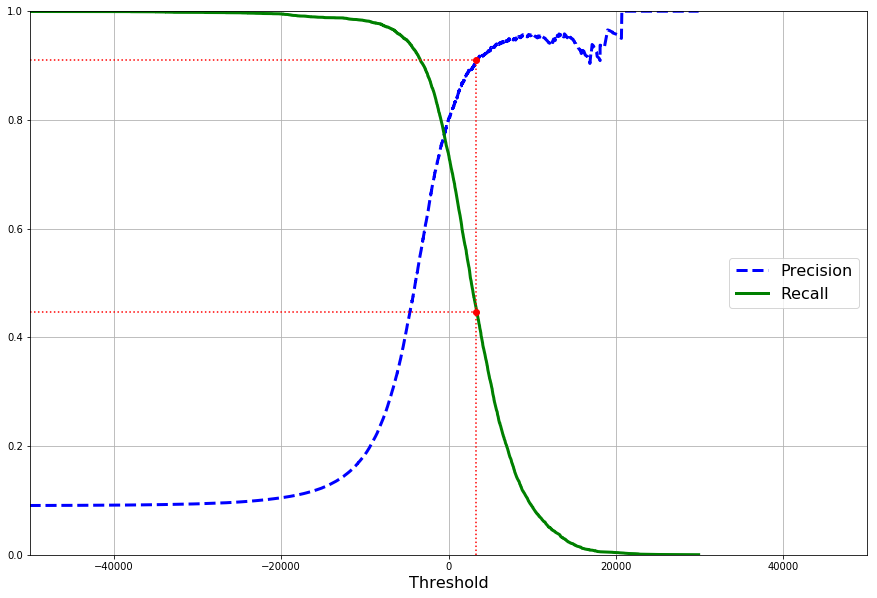

In [11]:
# Import precision_recall_curve for visualization
from sklearn.metrics import precision_recall_curve

# Return decision function for each observation passed through model
y_scores = cross_val_predict(sgd_clf, 
                             X_train, 
                             y_train_5, 
                             cv=3,
                             method='decision_function')

# Extract metrics
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Plot curves
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=3)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=3)
    plt.legend(loc='center right', fontsize=16) 
    plt.xlabel('Threshold', fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

plt.figure(figsize=(15, 10))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([3313, 3313], [0., 0.91], 'r:')         
plt.plot([-50000, 3313], [0.91, 0.91], 'r:')      
plt.plot([-50000, 3313], [0.4468, 0.4468], 'r:')
plt.plot([3313], [0.91], 'ro')                   
plt.plot([3313], [0.4468], 'ro')                

plt.show()

It becomes apparent when plotting the Precision/Recall curve that the `SGDClassifier` is approximately zero where both metrics are the same. The dotted red lines are just illustrating the tradeoff at an arbitrary threshold of '3313.' Anothere way to visualize and choose a threshold value is by plotting Precision and Recall against each other and selecting a threshold value that maximizes both values -- in this case *Recall = 0.4368* and *Precision = 0.91*

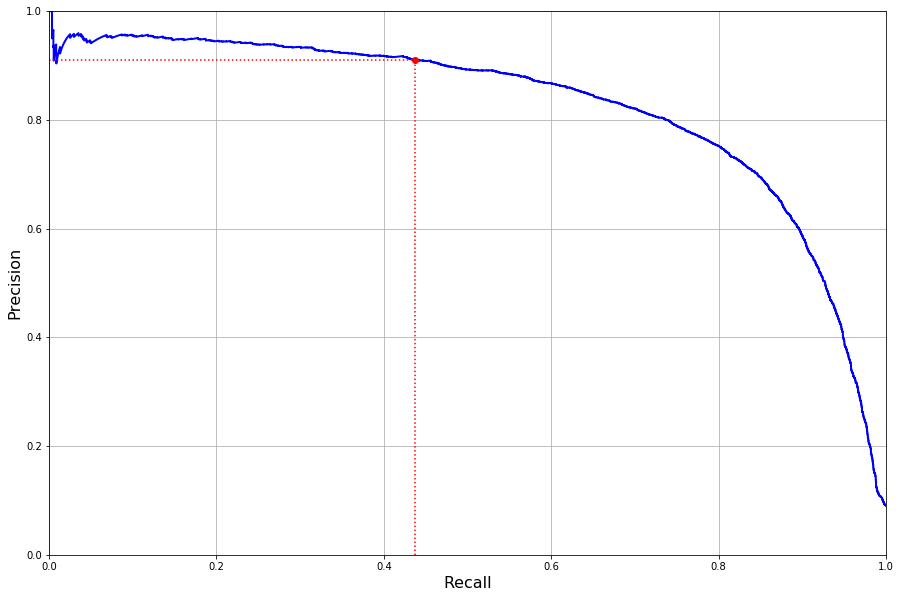

In [12]:
# Plot Precision vs. Recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(15, 10))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.91], 'r:')
plt.plot([0.0, 0.4368], [0.91, 0.91], 'r:')
plt.plot([0.4368], [0.91], 'ro')

plt.show()

However, it's better to be more precise than just eye-ball the graph. If a model with, say, 90% Precision were desired, the following code could be used to both find the threshold and make predictions using that value:

In [13]:
# Import Precision and Recall Score functions
from sklearn.metrics import precision_score, recall_score

# Find threshold with 0.90 Precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# Make predictions with new threshold value
y_train_pred_90 = (y_scores >= threshold_90_precision)

# Print Precision and Recall
print('Precision:', precision_score(y_train_5, y_train_pred_90), '\n',
      'Recall:', recall_score(y_train_5, y_train_pred_90))

Precision: 0.9001401541695866 
 Recall: 0.47389780483305666


So Precision is set at 90%, but Recall is *very* low which means a lot of 5's are not being correctly identified by the model. 

## The ROC Curve
The **Receiver Operating Characteristic** or **ROC Curve** is a tool for evaluating and comparing binary classifiers similar to what was previously seen with Precision/Recall Curves. ROC Curves plot the **True Positive Rate (TPR)** (same as Recall) against the **False Positive Rate (FPR)**, or the ratio of non-5's classified as 5's in the case of this classifier.

The code below first calculates the TPR/FPR then plots the resulting ROC curve:

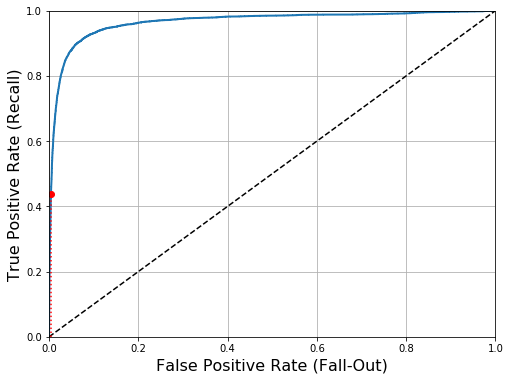

In [14]:
# Import ROC Curve function
from sklearn.metrics import roc_curve

# Calculate TPR/FPR
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# Function to plot ROC Curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], 'r:') 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], 'r:')  
plt.plot([4.837e-3], [0.4368], 'ro')               

plt.show()

As Recall increases, so does the FPR -- another tradeoff. ROC Curves should tend towards the top left since if they fell along the dotted line, that would be indicitive of random guessing. The **Area Under the Curve** or **AUC** metric measures exactly what it sounds like. The close the AUC is to '1', the better the classifier is at correctly identifying observations that are 5's and *not* misclassifying non-5's.

In [15]:
# Calculate AUC
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9655156053078885

AUC is mostly used for comparing different classifiers where a higher AUC indicates a better classifier. Below, a Random Forest classifier is built and compared with the existing SGD classifier used up to this point. Random Forest doesn't have a means of extracting the decision function like SGD so the `predict_proba()` function needs to be used which returns a vector of probabilities for an observation's class. Then, by selecting the probabilities for the positive class (i.e. '5'), the TPR and FPR can be extracted for building the ROC Curve.

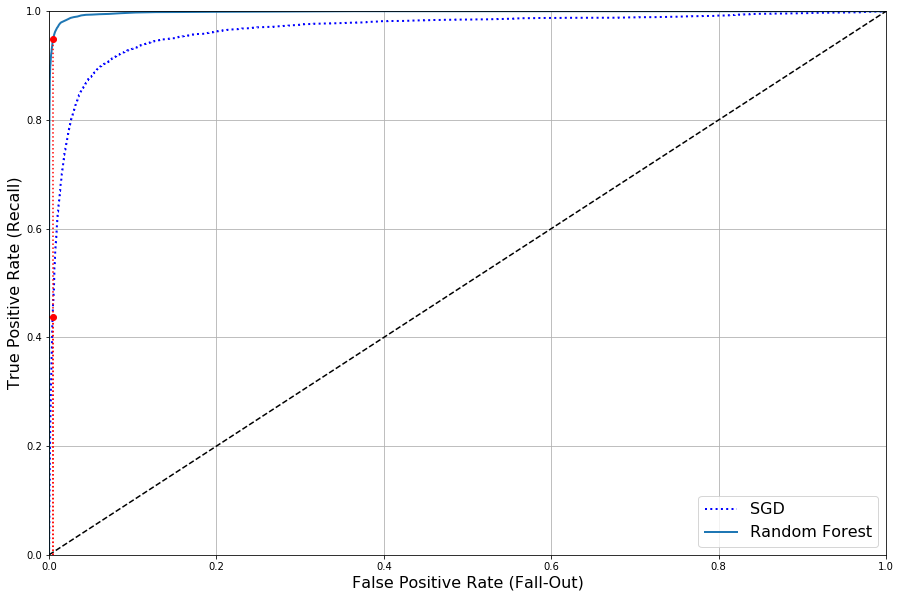

In [17]:
# Train Random Forest and extract class probabilities
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=734)

y_probas_forest = cross_val_predict(forest_clf, 
                                    X_train, 
                                    y_train_5, 
                                    cv=3,
                                    method='predict_proba')

# Extract probability of membership to positive ('5') class
y_scores_forest = y_probas_forest[:, 1] 

# Calculate TPR/FPR
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# Plot ROC Curve
plt.figure(figsize=(15, 10))
plt.plot(fpr, tpr, 'b:', linewidth=2, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], 'r:')
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], 'r:')
plt.plot([4.837e-3], [0.4368], 'ro')
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], 'r:')
plt.plot([4.837e-3], [0.9487], 'ro')
plt.grid(True)
plt.legend(loc='lower right', fontsize=16)

plt.show()

Then, comparing the AUC for each indicates Random Forest performs better than SGD:

In [19]:
# Print AUC for each classifier
print('SGD AUC:', roc_auc_score(y_train_5, y_scores),'\n', 
      'RF AUC:', roc_auc_score(y_train_5, y_scores_forest))

SGD AUC: 0.9655156053078885 
 RF AUC: 0.9983142398722824


## Multiclass classification
With **Multiclass classification** a classifer is tasked with correctly identifying an observation's class out of more than two possibilities. **Scikit-Learn** is able to detect when using a binary classifier for multiclass classification and (usually) automatically runs **OvA** to accommodate (although some classifiers like Support Vector Machines will use **OvO** instead). Below, a Support Vector Machine is trained on the *entire* MNIST data set. Now the classifier is multiclass -- it attempts to classify an observation as 0-9 rather than just '5' or 'non-5'.

In [21]:
# Train SVM for multiclass classification
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto', random_state=734)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

The `.decision_function` method can be called on the classifier object to verify that all 10 digits were considered. The highest score was for '5'.

In [24]:
# Check scores of decision function
some_digit_scores = svm_clf.decision_function([some_digit])
print('Decision scores:', some_digit_scores, '\n',
      'Top score:', np.argmax(some_digit_scores))

Decision scores: [[ 2.81585438  7.09167958  3.82972099  0.79365551  5.8885703   9.29718395
   1.79862509  8.10392157 -0.228207    4.83753243]] 
 Top Score: 5


## Multilabel classification
What if an observation can belong to *multiple* binary classes? Imagine a classifier that first identifies if a handwritten digit is greater than '6' and if it is, it gets classified as 'Large'. Also, the classifier tries to determine if the digit is 'Even' or 'Odd' (assuming only digits 0-9 are allowed). This means each digit can be classified as belonging to more than one binary class. This is called **multilabel classification**.

Below, a classifier is trained to do just this using the **K-Nearest Neighbors** algorithm which supports multilable classification (not all classifers do). First, the two criteria for each classification are set (`y_train_large` and `y_train_odd`). Then these are stacked into a label that combines both (`y_multilabel`).



In [28]:
# Create multilabel classifier
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

The resulting output from the classifier gives results for each binary classification first indicating 'False' for whether the digit is greater than '6' and 'True' for whether the digit is 'odd.'

## Multioutput classification
**Multioutput classification** takes things a step further. Now in addition to having more than one class an observation can belong to, each classification can take on multiple values. 

Illustrated below is a classifier designed to remove noise from an image. The input data is a noisy image while the output is a 'clean' image. Since the classifier will use MNIST digits, the image is represented as an array of pixel intensity values, 0-255. This is considered multioutput since each pixel is a label the classifier needs to predict (784 in total) and each pixel can take on any value between 0-255.

As a side note, sometimes it becomes hard to tel whether or not an ML problem is classification or regression. Since this example is *technically* predicting a numeric value, it could be considered regression. Additionally, a multioutput ML model could output *both* a class label and a numeric label.

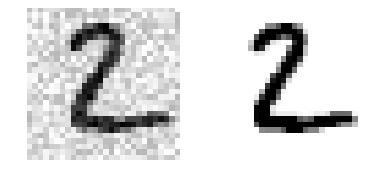

In [37]:
# Create training/testing data sets with image noise
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

# Plot a sample digit
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, 
               cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 1

plt.subplot(121) 
plot_digit(X_test_mod[some_index])
plt.subplot(122)
plot_digit(y_test_mod[some_index])

plt.show()

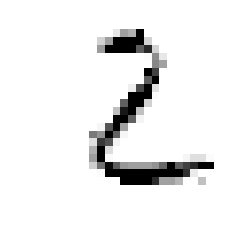

In [38]:
# Fit model and visualize
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

### Congrats! That's the end of the Classification lab!

## Exercise
### Q1:
Create a classifier for the MNIST data set that achieves **97% Accuracy** on the test set. A list of classifiers available in **Scikit-Learn** is [here](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Using a hyperparameter optimization technique like **grid search** or **random search** may elicit better results but be careful as they can sometimes make training time *extremely* long. 

Finish by printing out the Accuracy score, best model parameters, and best score.

**NOTE:**
* Always set `random_state=734` when applicable so everyone obtains the same answers
* Setting the menu item *Runtime-->Change runtime type* to **GPU** or **TPU** can improve speed

In [0]:
# Import packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Create parameter grid
param_grid = [
              {'weights': ['uniform', 'distance'], 
               'n_neighbors': [3, 4, 5]}
]

# Instantiate and train KNN with grid search
knn_clf = KNeighborsClassifier()

grid_search = GridSearchCV(knn_clf, 
                           param_grid, 
                           cv=5, 
                           verbose=3,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# Predict and print Accuracy, best model parameters, and best score
y_pred = grid_search.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred), '\n',
      'Best Parameters:', grid_search.best_params_, '\n',
      'Best Score:', grid_search.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
